In [0]:
#%run ./init

INFO: Trying to read image from: /dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_4.png
INFO: Image loaded successfully.


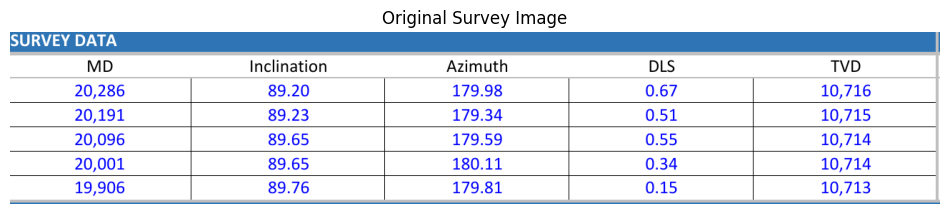

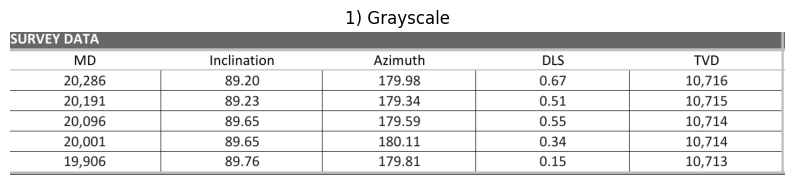

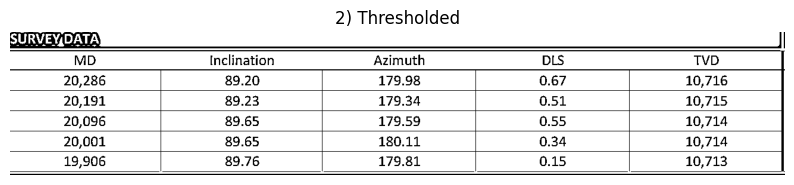

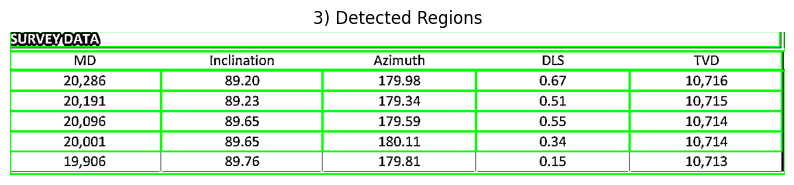

INFO: OCR Box (0,0,1302,33): SURVEY DATA |
INFO: OCR Box (0,0,1293,26): SURVEY DATA
INFO: OCR Box (0,34,1296,30): MD Inclination Azimuth DLS TVD
INFO: OCR Box (0,66,1302,173): 20,286 89.20 179.98 0.67 10,716
19,906 89.76 179.81 0.15 10,713
INFO: OCR Box (0,66,253,33): 20,286
INFO: OCR Box (254,66,270,33): 89.20
INFO:SurveyExtractor:OCR Box (254,66,270,33): 89.20
INFO: OCR Box (525,66,257,33): 179.98
INFO:SurveyExtractor:OCR Box (525,66,257,33): 179.98
INFO: OCR Box (783,66,257,33): 0.67
INFO:SurveyExtractor:OCR Box (783,66,257,33): 0.67
INFO: OCR Box (1041,66,255,33): 10,716
INFO:SurveyExtractor:OCR Box (1041,66,255,33): 10,716
INFO: OCR Box (0,100,253,33): 20,191
INFO:SurveyExtractor:OCR Box (0,100,253,33): 20,191
INFO: OCR Box (254,100,270,33): 89.23
INFO:SurveyExtractor:OCR Box (254,100,270,33): 89.23
INFO: OCR Box (525,100,257,33): 179.34
INFO:SurveyExtractor:OCR Box (525,100,257,33): 179.34
INFO: OCR Box (783,100,257,33): 0.51
INFO:SurveyExtractor:OCR Box (783,100,257,33): 0.51
IN

----- Extracted DataFrame -----
       MD Inclination Azimuth     DLS     TVD
0  20,286       89.20  179.98    0.67  10,716
1  20,191       89.23  179.34    0.51  10,715
2  20,096       89.65  179.59    0.55  10,714
3  20,001       89.65  180.11    0.34  10,714
4  19,906       89.76  179.81    0.15  10,713
5  SURVEY        DATA       |  SURVEY    DATA


In [0]:
import os
import re
import cv2
import pytesseract
import numpy as np
import pandas as pd
import logging
import json
import matplotlib.pyplot as plt
import math

# ---------------------------------------------------------------------
# Logger Setup
# ---------------------------------------------------------------------
logger = logging.getLogger("SurveyExtractor")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    logger.addHandler(handler)

# ---------------------------------------------------------------------
# Utility: show_image
# ---------------------------------------------------------------------
def show_image(title, img, cmap=None, size=(10,10)):
    plt.figure(figsize=size)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# ---------------------------------------------------------------------
# safe_read_image
# ---------------------------------------------------------------------
def safe_read_image(img_path):
    """
    Reads an image from a DBFS or local path.
    """
    if img_path.startswith("dbfs:"):
        local_path = img_path.replace("dbfs:", "/dbfs")
    else:
        local_path = img_path
    logger.info(f"Trying to read image from: {local_path}")
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise FileNotFoundError(f"OpenCV failed to read the image: {local_path}")
    return img

# ---------------------------------------------------------------------
# preprocess_image
# ---------------------------------------------------------------------
def preprocess_image(img, debug=False):
    """
    Converts image to grayscale and applies adaptive thresholding.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if debug:
        show_image("1) Grayscale", gray, cmap="gray")
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 9
    )
    if debug:
        show_image("2) Thresholded", thresh, cmap="gray")
    return thresh

# ---------------------------------------------------------------------
# detect_text_regions
# ---------------------------------------------------------------------
def detect_text_regions(thresh_img, debug=False):
    """
    Detects text regions (bounding boxes) from the thresholded image.
    """
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        show_image("3) Detected Regions", debug_img)
    return rois

# ---------------------------------------------------------------------
# perform_ocr_on_rois
# ---------------------------------------------------------------------
def perform_ocr_on_rois(img, rois, debug=False):
    """
    Performs OCR on each detected text region.
    Returns a list of tuples: (x, y, w, h, text).
    """
    results = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip()
        if not text:
            text = "[BLANK]"
        results.append((x, y, w, h, text))
        if debug:
            logger.info(f"OCR Box ({x},{y},{w},{h}): {text}")
    return results

# ---------------------------------------------------------------------
# build_survey_dict_from_rois
# ---------------------------------------------------------------------
def build_survey_dict_from_rois(roi_texts, expected_headers):
    """
    Groups OCR results (list of (x,y,w,h,text)) into rows by y coordinate,
    joins text for each row, splits them by newline and multiple spaces,
    then parses each candidate row into tokens.
    Only rows with at least len(expected_headers) tokens are kept.
    Returns a list of dictionaries (one per valid row).
    """
    row_tolerance = 10
    rows = []
    current_row = []
    prev_y = None

    # Group by similar y coordinate.
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)

    # Join texts in each row (sorted by x) and log.
    row_strings = []
    for i, row in enumerate(rows):
        row.sort(key=lambda c: c[0])
        line = " ".join(cell[4] for cell in row)
        row_strings.append(line)
        logger.info(f"Grouped Row {i}: {line}")
    
    # Split joined rows by newline if present.
    all_lines = []
    for line in row_strings:
        split_lines = line.split("\n")
        for subline in split_lines:
            subline = subline.strip()
            if subline:
                all_lines.append(subline)
    logger.info(f"All extracted lines: {all_lines}")
    
    # Filter out header lines (if they contain known column names) and parse rows.
    data_lines = []
    for line in all_lines:
        # Split using multiple spaces.
        tokens = re.split(r'\s{2,}', line)
        if len(tokens) == 1:
            tokens = line.split()
        lower_tokens = [t.lower() for t in tokens]
        if "md" in lower_tokens and "inclination" in lower_tokens:
            logger.info(f"Skipping header line: {tokens}")
            continue
        if len(tokens) < len(expected_headers):
            logger.warning(f"Line has fewer tokens than expected: {tokens}")
            continue
        # If extra tokens exist, take only the first expected_headers number.
        tokens = tokens[:len(expected_headers)]
        data_lines.append(tokens)
    
    logger.info(f"Data lines to parse: {data_lines}")
    
    # Build list of dictionaries.
    survey_list = []
    for tokens in data_lines:
        row_dict = {expected_headers[i]: tokens[i] for i in range(len(expected_headers))}
        survey_list.append(row_dict)
    return survey_list

# ---------------------------------------------------------------------
# sort_survey_data
# ---------------------------------------------------------------------
def sort_survey_data(survey_list):
    """
    Sorts the survey list in descending order based on the MD value.
    MD values are expected as strings with commas (e.g., "20,286").
    """
    def md_value(row):
        try:
            return float(row["MD"].replace(",", ""))
        except Exception:
            return 0
    sorted_list = sorted(survey_list, key=md_value, reverse=True)
    return sorted_list

# ---------------------------------------------------------------------
# main_survey_pipeline
# ---------------------------------------------------------------------
def main_survey_pipeline():
    # Expected columns for the survey table.
    expected_headers = ["MD", "Inclination", "Azimuth", "DLS", "TVD"]
    
    # Set the path to your survey image.
    survey_img_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_4.png"
    
    try:
        img = safe_read_image(survey_img_path)
        logger.info("Image loaded successfully.")
    except Exception as e:
        logger.error(e)
        return

    # Display the original image.
    show_image("Original Survey Image", img, size=(12,12))
    
    # Preprocess the image.
    thresh_img = preprocess_image(img, debug=True)
    
    # Detect text regions.
    rois = detect_text_regions(thresh_img, debug=True)
    
    # Perform OCR on each detected region.
    roi_texts = perform_ocr_on_rois(img, rois, debug=True)
    
    # Log the raw OCR outputs.
    for i, (x, y, w, h, text) in enumerate(roi_texts):
        logger.info(f"OCR Box {i}: {text}")
    
    # Build the survey data rows from OCR results.
    survey_list = build_survey_dict_from_rois(roi_texts, expected_headers)
    
    # Sort survey data by MD (descending) to match desired order.
    survey_list = sort_survey_data(survey_list)
    
    final_output = {"SURVEY DATA": survey_list}
    logger.info("===== FINAL SURVEY DATA =====")
    logger.info(json.dumps(final_output, indent=4))
    
    # Create and print a DataFrame.
    df = pd.DataFrame(survey_list)
    print("----- Extracted DataFrame -----")
    print(df)
    
    # Save outputs as JSON and CSV.
    output_folder = "dbfs:/mnt/mini-proj-dd/final_survey_results"
    local_folder = output_folder.replace("dbfs:", "/dbfs")
    os.makedirs(local_folder, exist_ok=True)
    
    out_json = os.path.join(local_folder, "survey_data.json")
    with open(out_json, "w") as f:
        json.dump(final_output, f, indent=4)
    logger.info(f"JSON saved to {out_json}")
    
    out_csv = os.path.join(local_folder, "survey_data.csv")
    df.to_csv(out_csv, index=False)
    logger.info(f"CSV saved to {out_csv}")

if __name__ == "__main__":
    main_survey_pipeline()


INFO: Trying to read image from: /dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_7.png
INFO:CasingExtractor:Trying to read image from: /dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_7.png
INFO: Image loaded successfully.
INFO:CasingExtractor:Image loaded successfully.


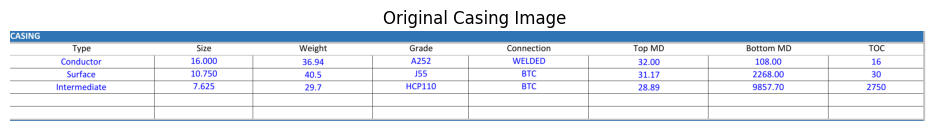

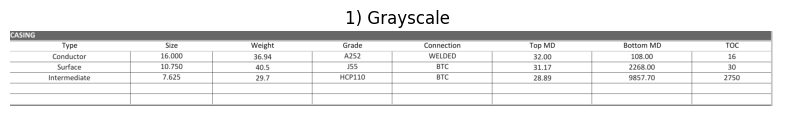

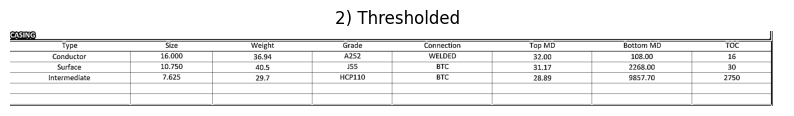

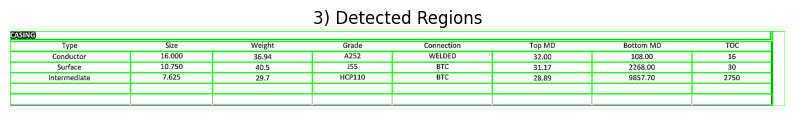

INFO: OCR Box (0,0,2460,33): CASING
INFO:CasingExtractor:OCR Box (0,0,2460,33): CASING
INFO: OCR Box (0,0,2454,26): CASING
INFO:CasingExtractor:OCR Box (0,0,2454,26): CASING
INFO: OCR Box (2462,0,40,241): [BLANK]
INFO:CasingExtractor:OCR Box (2462,0,40,241): [BLANK]
INFO: OCR Box (0,34,2457,30): Type Size Weight Grade Connection Top MD Bottom MD TOC
INFO:CasingExtractor:OCR Box (0,34,2457,30): Type Size Weight Grade Connection Top MD Bottom MD TOC
INFO: OCR Box (0,66,388,33): Conductor
INFO:CasingExtractor:OCR Box (0,66,388,33): Conductor
INFO: OCR Box (389,66,264,33): 16.000
INFO:CasingExtractor:OCR Box (389,66,264,33): 16.000
INFO: OCR Box (654,66,321,33): 36.94
INFO:CasingExtractor:OCR Box (654,66,321,33): 36.94
INFO: OCR Box (976,66,257,33): A252
INFO:CasingExtractor:OCR Box (976,66,257,33): A252
INFO: OCR Box (1234,66,322,33): WELDED
INFO:CasingExtractor:OCR Box (1234,66,322,33): WELDED
INFO: OCR Box (1557,66,321,33): 32.00
INFO:CasingExtractor:OCR Box (1557,66,321,33): 32.00
INFO

----- Extracted DataFrame -----
           Type     Size   Weight  ...   Top MD Bottom MD      TOC
0     Conductor   16.000    36.94  ...    32.00    108.00       16
1       Surface   10.750     40.5  ...    31.17   2268.00       30
2  Intermediate    7.625     29.7  ...    28.89   9857.70     2750
3       [BLANK]  [BLANK]  [BLANK]  ...  [BLANK]   [BLANK]  [BLANK]

[4 rows x 8 columns]


In [0]:
import os
import re
import cv2
import pytesseract
import numpy as np
import pandas as pd
import logging
import json
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Logger Setup
# ---------------------------------------------------------------------
logger = logging.getLogger("CasingExtractor")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    logger.addHandler(handler)

# ---------------------------------------------------------------------
# Utility: show_image
# ---------------------------------------------------------------------
def show_image(title, img, cmap=None, size=(10,10)):
    plt.figure(figsize=size)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# ---------------------------------------------------------------------
# safe_read_image
# ---------------------------------------------------------------------
def safe_read_image(img_path):
    """
    Reads an image from a DBFS or local path.
    """
    if img_path.startswith("dbfs:"):
        local_path = img_path.replace("dbfs:", "/dbfs")
    else:
        local_path = img_path
    logger.info(f"Trying to read image from: {local_path}")
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise FileNotFoundError(f"OpenCV failed to read the image: {local_path}")
    return img

# ---------------------------------------------------------------------
# preprocess_image
# ---------------------------------------------------------------------
def preprocess_image(img, debug=False):
    """
    Converts image to grayscale and applies adaptive thresholding.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if debug:
        show_image("1) Grayscale", gray, cmap="gray")
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 9
    )
    if debug:
        show_image("2) Thresholded", thresh, cmap="gray")
    return thresh

# ---------------------------------------------------------------------
# detect_text_regions
# ---------------------------------------------------------------------
def detect_text_regions(thresh_img, debug=False):
    """
    Detects text regions (bounding boxes) from the thresholded image.
    """
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    # Sort by y (top-to-bottom) then by x (left-to-right)
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        show_image("3) Detected Regions", debug_img)
    return rois

# ---------------------------------------------------------------------
# perform_ocr_on_rois
# ---------------------------------------------------------------------
def perform_ocr_on_rois(img, rois, debug=False):
    """
    Performs OCR on each detected text region.
    Returns a list of tuples: (x, y, w, h, text).
    """
    results = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip()
        if not text:
            text = "[BLANK]"
        results.append((x, y, w, h, text))
        if debug:
            logger.info(f"OCR Box ({x},{y},{w},{h}): {text}")
    return results

# ---------------------------------------------------------------------
# build_casing_dict_from_rois
# ---------------------------------------------------------------------
def build_casing_dict_from_rois(roi_texts, expected_headers):
    """
    Groups OCR results (list of (x, y, w, h, text)) into rows by y coordinate,
    joins text for each row (sorted by x), then parses each row into tokens.
    Rows containing header keywords (e.g., column names) are skipped.
    Returns a list of dictionaries (one per valid row).
    """
    row_tolerance = 10
    rows = []
    current_row = []
    prev_y = None

    # Group by similar y-coordinate.
    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)

    # Join texts in each row (sorted by x)
    row_strings = []
    for i, row in enumerate(rows):
        row.sort(key=lambda c: c[0])
        line = " ".join(cell[4] for cell in row)
        row_strings.append(line.strip())
        logger.info(f"Grouped Row {i}: {line}")

    # Split joined rows by newline if present.
    all_lines = []
    for line in row_strings:
        for subline in line.split("\n"):
            subline = subline.strip()
            if subline:
                all_lines.append(subline)
    logger.info(f"All extracted lines: {all_lines}")

    # Filter out header-like lines and build the data rows.
    data_lines = []
    for line in all_lines:
        tokens = re.split(r'\s{2,}', line)
        if len(tokens) == 1:
            tokens = line.split()
        lower_tokens = [t.lower() for t in tokens]
        # Skip rows that contain header keywords.
        if "type" in lower_tokens and "size" in lower_tokens:
            logger.info(f"Skipping header line: {tokens}")
            continue
        if len(tokens) < len(expected_headers):
            logger.warning(f"Line has fewer tokens than expected: {tokens}")
            continue
        tokens = tokens[:len(expected_headers)]
        data_lines.append(tokens)
    
    logger.info(f"Data lines to parse: {data_lines}")

    # Build list of dictionaries.
    casing_list = []
    for tokens in data_lines:
        row_dict = {expected_headers[i]: tokens[i] for i in range(len(expected_headers))}
        casing_list.append(row_dict)
    return casing_list

# ---------------------------------------------------------------------
# main_casing_pipeline
# ---------------------------------------------------------------------
def main_casing_pipeline():
    # Expected columns for the casing table.
    expected_headers = ["Type", "Size", "Weight", "Grade", "Connection", "Top MD", "Bottom MD", "TOC"]
    
    # Set the path to your casing image.
    casing_img_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_7.png"
    
    try:
        img = safe_read_image(casing_img_path)
        logger.info("Image loaded successfully.")
    except Exception as e:
        logger.error(e)
        return

    # Display the original image.
    show_image("Original Casing Image", img, size=(12,12))
    
    # Preprocess the image.
    thresh_img = preprocess_image(img, debug=True)
    
    # Detect text regions.
    rois = detect_text_regions(thresh_img, debug=True)
    
    # Perform OCR on each detected region.
    roi_texts = perform_ocr_on_rois(img, rois, debug=True)
    
    # Log the raw OCR outputs.
    for i, (x, y, w, h, text) in enumerate(roi_texts):
        logger.info(f"OCR Box {i}: {text}")
    
    # Build the casing data rows from OCR results.
    casing_list = build_casing_dict_from_rois(roi_texts, expected_headers)
    
    # Create final output dictionary.
    final_output = {"CASING": casing_list}
    logger.info("===== FINAL CASING DATA =====")
    logger.info(json.dumps(final_output, indent=4))
    
    # Create and print a DataFrame.
    df = pd.DataFrame(casing_list)
    print("----- Extracted DataFrame -----")
    print(df)
    
    # Save outputs as JSON and CSV.
    output_folder = "dbfs:/mnt/mini-proj-dd/final_casing_results"
    local_folder = output_folder.replace("dbfs:", "/dbfs")
    os.makedirs(local_folder, exist_ok=True)
    
    out_json = os.path.join(local_folder, "casing_data.json")
    with open(out_json, "w") as f:
        json.dump(final_output, f, indent=4)
    logger.info(f"JSON saved to {out_json}")
    
    out_csv = os.path.join(local_folder, "casing_data.csv")
    df.to_csv(out_csv, index=False)
    logger.info(f"CSV saved to {out_csv}")

if __name__ == "__main__":
    main_casing_pipeline()


INFO: Trying to read image from: /dbfs/mnt/mini-proj-dd/cropped_sections/page_2_section_2.png
INFO:consumablesExtractor:Trying to read image from: /dbfs/mnt/mini-proj-dd/cropped_sections/page_2_section_2.png
INFO: Image loaded successfully.
INFO:consumablesExtractor:Image loaded successfully.


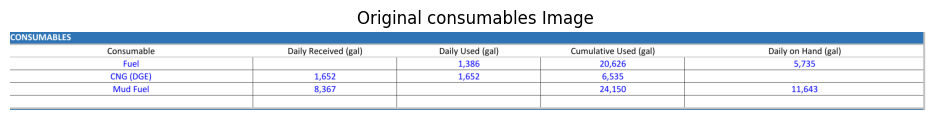

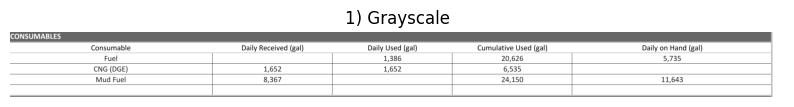

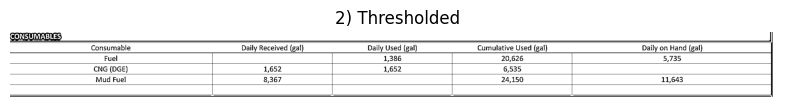

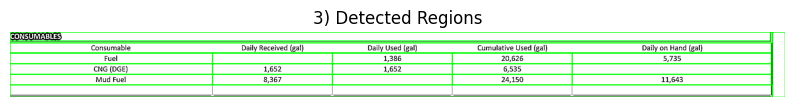

INFO: OCR Box (0,0,2460,34): CONSUMABLES
INFO:consumablesExtractor:OCR Box (0,0,2460,34): CONSUMABLES
INFO: OCR Box (0,0,2454,28): CONSUMABLES
INFO:consumablesExtractor:OCR Box (0,0,2454,28): CONSUMABLES
INFO: OCR Box (2462,0,40,209): [BLANK]
INFO:consumablesExtractor:OCR Box (2462,0,40,209): [BLANK]
INFO: OCR Box (0,35,2457,31): Consumable Daily Received (gal) Daily Used (gal) Cumulative Used (gal) Daily on Hand (gal)
INFO:consumablesExtractor:OCR Box (0,35,2457,31): Consumable Daily Received (gal) Daily Used (gal) Cumulative Used (gal) Daily on Hand (gal)
INFO: OCR Box (0,68,653,33): Fuel
INFO:consumablesExtractor:OCR Box (0,68,653,33): Fuel
INFO: OCR Box (654,68,386,33): [BLANK]
INFO:consumablesExtractor:OCR Box (654,68,386,33): [BLANK]
INFO: OCR Box (1041,68,386,33): 1,386
INFO:consumablesExtractor:OCR Box (1041,68,386,33): 1,386
INFO: OCR Box (1428,68,386,33): 20,626
INFO:consumablesExtractor:OCR Box (1428,68,386,33): 20,626
INFO: OCR Box (1815,68,642,33): 5,735
INFO:consumablesEx

----- Extracted DataFrame -----
  Consumable Daily Received (gal)  ... Cumulative Used (gal) Daily on Hand (gal)
0       Fuel              [BLANK]  ...                20,626               5,735
1  CNG (DGE)                1,652  ...                 6,535             [BLANK]
2   Mud Fuel                8,367  ...                24,150              11,643

[3 rows x 5 columns]


In [0]:
import os
import re
import cv2
import pytesseract
import numpy as np
import pandas as pd
import logging
import json
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Logger Setup
# ---------------------------------------------------------------------
logger = logging.getLogger("consumablesExtractor")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    logger.addHandler(handler)

# ---------------------------------------------------------------------
# Utility: show_image
# ---------------------------------------------------------------------
def show_image(title, img, cmap=None, size=(10,10)):
    plt.figure(figsize=size)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# ---------------------------------------------------------------------
# safe_read_image
# ---------------------------------------------------------------------
def safe_read_image(img_path):
    """
    Reads an image from a DBFS or local path.
    """
    if img_path.startswith("dbfs:"):
        local_path = img_path.replace("dbfs:", "/dbfs")
    else:
        local_path = img_path
    logger.info(f"Trying to read image from: {local_path}")
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise FileNotFoundError(f"OpenCV failed to read the image: {local_path}")
    return img

# ---------------------------------------------------------------------
# preprocess_image
# ---------------------------------------------------------------------
def preprocess_image(img, debug=False):
    """
    Converts image to grayscale and applies adaptive thresholding.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if debug:
        show_image("1) Grayscale", gray, cmap="gray")
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 9
    )
    if debug:
        show_image("2) Thresholded", thresh, cmap="gray")
    return thresh

# ---------------------------------------------------------------------
# detect_text_regions
# ---------------------------------------------------------------------
def detect_text_regions(thresh_img, debug=False):
    """
    Detects text regions (bounding boxes) from the thresholded image.
    """
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # A basic size filter to skip very small or very thin boxes
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
    # Sort by y then x
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in rois:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
        show_image("3) Detected Regions", debug_img)
    return rois

# ---------------------------------------------------------------------
# perform_ocr_on_rois
# ---------------------------------------------------------------------
def perform_ocr_on_rois(img, rois, debug=False):
    """
    Performs OCR on each detected text region.
    Returns a list of tuples: (x, y, w, h, text).
    """
    results = []
    for (x, y, w, h) in rois:
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip()
        # Replace empty OCR results with a placeholder.
        if not text:
            text = "[BLANK]"
        results.append((x, y, w, h, text))
        if debug:
            logger.info(f"OCR Box ({x},{y},{w},{h}): {text}")
    return results

# ---------------------------------------------------------------------
# build_consumables_dict_from_rois
# ---------------------------------------------------------------------
def build_consumables_dict_from_rois(roi_texts):
    """
    Groups OCR results into rows based on similar y-coordinate.
    Skips header rows and selects only data rows.
    Then, for each data row, it parses tokens to produce exactly five columns:
      "Consumable", "Daily Received (gal)", "Daily Used (gal)",
      "Cumulative Used (gal)", "Daily on Hand (gal)"
    We keep "[BLANK]" tokens so each row has exactly 5 columns, even if
    some columns are blank.
    """
    row_tolerance = 10
    rows = []
    current_row = []
    prev_y = None

    for (x, y, w, h, text) in roi_texts:
        if prev_y is None or abs(y - prev_y) <= row_tolerance:
            current_row.append((x, y, w, h, text))
        else:
            rows.append(current_row)
            current_row = [(x, y, w, h, text)]
        prev_y = y
    if current_row:
        rows.append(current_row)

    # Join texts in each row (sorted by x)
    grouped_rows = []
    for i, row in enumerate(rows):
        row.sort(key=lambda cell: cell[0])  # sort by x-coordinate
        line = " ".join(cell[4] for cell in row).strip()
        grouped_rows.append(line)
        logger.info(f"Grouped Row {i}: {line}")

    # Filter out header or unwanted rows by checking for keywords
    data_rows = []
    for line in grouped_rows:
        lower_line = line.lower()
        # Skip lines that look like headers
        if ("consumable" in lower_line and "received" in lower_line) or "nun" in lower_line:
            continue
        # If too few tokens, skip
        if len(line.split()) < 5:
            continue
        data_rows.append(line)

    logger.info(f"Data rows to parse: {data_rows}")

    consumables_list = []
    for line in data_rows:
        # First split on single or multiple spaces
        tokens = re.split(r'\s+', line)
        # ---------------------------------------------------------------------
        # IMPORTANT CHANGE: Do NOT remove "[BLANK]" tokens here.
        # ---------------------------------------------------------------------
        # If there are more than 5 tokens, merge extras into the first field
        # so we end up with exactly 5 tokens total.
        if len(tokens) > 5:
            # everything except the last 4 tokens becomes "Consumable"
            first = " ".join(tokens[:-4])
            last4 = tokens[-4:]
            tokens = [first] + last4

        # Now we must have exactly 5 tokens to parse
        if len(tokens) != 5:
            logger.warning(f"Skipping row (unexpected token count): {tokens}")
            continue

        row_dict = {
            "Consumable":             tokens[0],
            "Daily Received (gal)":   tokens[1],
            "Daily Used (gal)":       tokens[2],
            "Cumulative Used (gal)":  tokens[3],
            "Daily on Hand (gal)":    tokens[4]
        }
        consumables_list.append(row_dict)

    return consumables_list

# ---------------------------------------------------------------------
# main_consumables_pipeline
# ---------------------------------------------------------------------
def main_consumables_pipeline():
    # Set the path to your consumables image.
    consumables_img_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_2_section_2.png"
    
    try:
        img = safe_read_image(consumables_img_path)
        logger.info("Image loaded successfully.")
    except Exception as e:
        logger.error(e)
        return

    # Display the original image (optional).
    show_image("Original consumables Image", img, size=(12,12))
    
    # Preprocess the image.
    thresh_img = preprocess_image(img, debug=True)
    
    # Detect text regions.
    rois = detect_text_regions(thresh_img, debug=True)
    
    # Perform OCR on each detected region.
    roi_texts = perform_ocr_on_rois(img, rois, debug=True)
    
    # Log the raw OCR outputs.
    for i, (x, y, w, h, text) in enumerate(roi_texts):
        logger.info(f"OCR Box {i}: {text}")
    
    # Build the consumables data rows from OCR results.
    consumables_list = build_consumables_dict_from_rois(roi_texts)
    
    # Create final output dictionary.
    final_output = {"CONSUMABLES": consumables_list}
    logger.info("===== FINAL CONSUMABLES DATA =====")
    logger.info(json.dumps(final_output, indent=4))
    
    # Create and print a DataFrame.
    df = pd.DataFrame(consumables_list)
    print("----- Extracted DataFrame -----")
    print(df)
    
    # Save outputs as JSON and CSV.
    output_folder = "dbfs:/mnt/mini-proj-dd/final_consumables_results"
    local_folder = output_folder.replace("dbfs:", "/dbfs")
    os.makedirs(local_folder, exist_ok=True)
    
    out_json = os.path.join(local_folder, "consumables_data.json")
    with open(out_json, "w") as f:
        json.dump(final_output, f, indent=4)
    logger.info(f"JSON saved to {out_json}")
    
    out_csv = os.path.join(local_folder, "consumables_data.csv")
    df.to_csv(out_csv, index=False)
    logger.info(f"CSV saved to {out_csv}")

if __name__ == "__main__":
    main_consumables_pipeline()


INFO: Image loaded from /dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_9.png with shape (241, 1560, 3)
INFO:PersonnelExtractor:Image loaded from /dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_9.png with shape (241, 1560, 3)
INFO: Image loaded successfully.
INFO:PersonnelExtractor:Image loaded successfully.


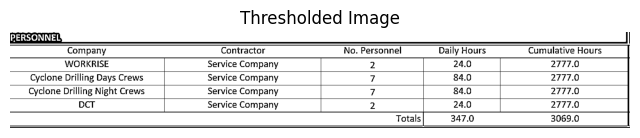

DEBUG: Detected 25 text regions.
DEBUG:PersonnelExtractor:Detected 25 text regions.


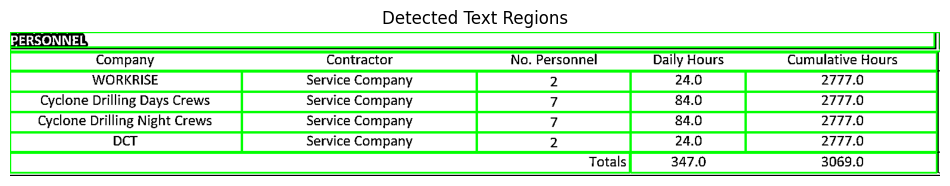

DEBUG: ROI 1: bbox=(0, 0, 1560, 32), extracted text: 'PERSONNEL |'
DEBUG:PersonnelExtractor:ROI 1: bbox=(0, 0, 1560, 32), extracted text: 'PERSONNEL |'
DEBUG: ROI 2: bbox=(0, 0, 1550, 25), extracted text: 'PERSONNEL'
DEBUG:PersonnelExtractor:ROI 2: bbox=(0, 0, 1550, 25), extracted text: 'PERSONNEL'
DEBUG: ROI 3: bbox=(0, 34, 1554, 30), extracted text: 'Company Contractor No. Personnel Daily Hours Cumulative Hours'
DEBUG:PersonnelExtractor:ROI 3: bbox=(0, 34, 1554, 30), extracted text: 'Company Contractor No. Personnel Daily Hours Cumulative Hours'
DEBUG: ROI 4: bbox=(0, 66, 388, 33), extracted text: 'WORKRISE'
DEBUG:PersonnelExtractor:ROI 4: bbox=(0, 66, 388, 33), extracted text: 'WORKRISE'
DEBUG: ROI 5: bbox=(389, 66, 393, 33), extracted text: 'Service Company'
DEBUG:PersonnelExtractor:ROI 5: bbox=(389, 66, 393, 33), extracted text: 'Service Company'
DEBUG: ROI 6: bbox=(783, 66, 257, 33), extracted text: '2'
DEBUG:PersonnelExtractor:ROI 6: bbox=(783, 66, 257, 33), extracted text: '2'


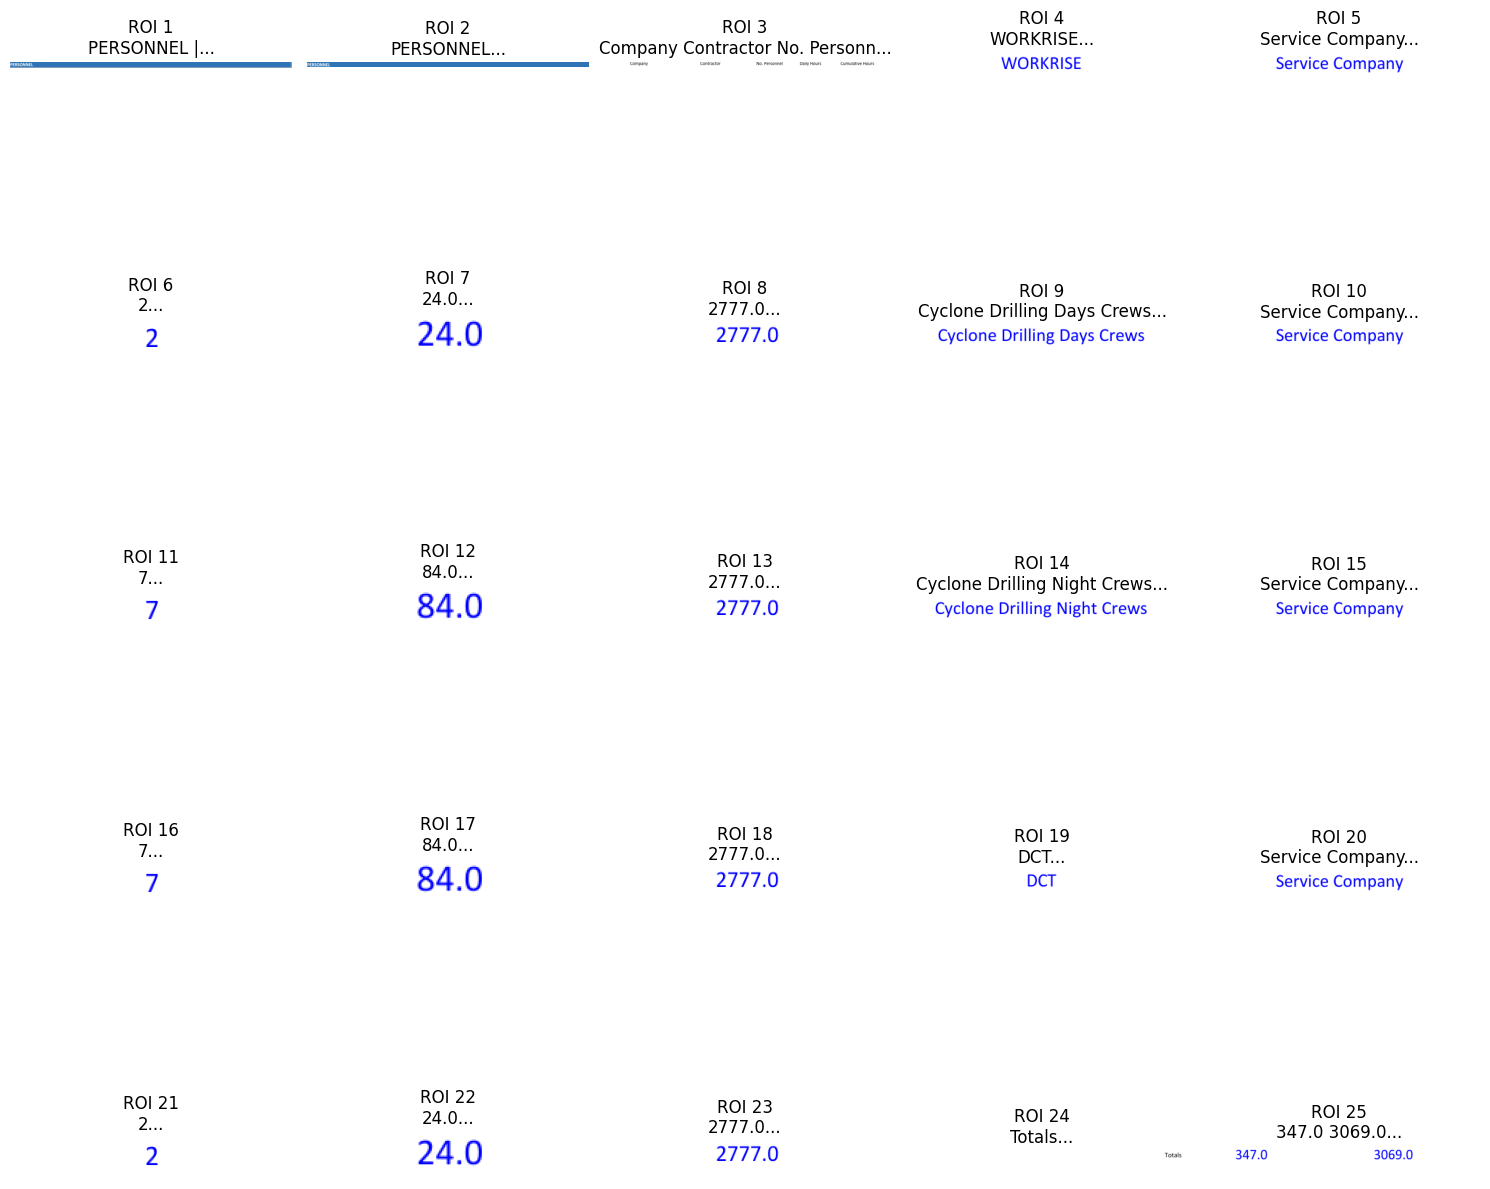

DEBUG: Grouped ROIs into 7 rows.
DEBUG:PersonnelExtractor:Grouped ROIs into 7 rows.
DEBUG: Grouped rows: [[(0, 0, 1550, 25, 'PERSONNEL'), (0, 0, 1560, 32, 'PERSONNEL |')], [(0, 34, 1554, 30, 'Company Contractor No. Personnel Daily Hours Cumulative Hours')], [(0, 66, 388, 33, 'WORKRISE'), (389, 66, 393, 33, 'Service Company'), (783, 66, 257, 33, '2'), (1041, 66, 192, 33, '24.0'), (1234, 66, 320, 33, '2777.0')], [(0, 100, 388, 33, 'Cyclone Drilling Days Crews'), (389, 100, 393, 33, 'Service Company'), (783, 100, 257, 33, '7'), (1041, 100, 192, 33, '84.0'), (1234, 100, 320, 33, '2777.0')], [(0, 134, 388, 33, 'Cyclone Drilling Night Crews'), (389, 134, 393, 33, 'Service Company'), (783, 134, 257, 33, '7'), (1041, 134, 192, 33, '84.0'), (1234, 134, 320, 33, '2777.0')], [(0, 168, 388, 32, 'DCT'), (389, 168, 393, 32, 'Service Company'), (783, 168, 257, 32, '2'), (1041, 168, 192, 32, '24.0'), (1234, 168, 320, 32, '2777.0')], [(0, 202, 1039, 33, 'Totals'), (1041, 202, 513, 33, '347.0 3069.0')]]

=== Extracted Data ===
{
    "PERSONNEL": [
        {
            "Company": "WORKRISE",
            "Contractor": "Service Company",
            "No. Personnel": 2,
            "Daily Hours": 24,
            "Cumulative Hours": 2777
        },
        {
            "Company": "Cyclone Drilling Days Crews",
            "Contractor": "Service Company",
            "No. Personnel": 7,
            "Daily Hours": 84,
            "Cumulative Hours": 2777
        },
        {
            "Company": "Cyclone Drilling Night Crews",
            "Contractor": "Service Company",
            "No. Personnel": 7,
            "Daily Hours": 84,
            "Cumulative Hours": 2777
        },
        {
            "Company": "DCT",
            "Contractor": "Service Company",
            "No. Personnel": 2,
            "Daily Hours": 24,
            "Cumulative Hours": 2777
        },
        {
            "Company": "",
            "Contractor": "",
            "No. Personnel": "Totals",
            

Company,Contractor,No. Personnel,Daily Hours,Cumulative Hours
WORKRISE,Service Company,2,24,2777
Cyclone Drilling Days Crews,Service Company,7,84,2777
Cyclone Drilling Night Crews,Service Company,7,84,2777
DCT,Service Company,2,24,2777
,,Totals,347,3069.0


INFO: Final DataFrame saved to /dbfs/mnt/mini-proj-dd/final_ocr_results/page_1_section_9_personnel_ocr.csv
INFO:PersonnelExtractor:Final DataFrame saved to /dbfs/mnt/mini-proj-dd/final_ocr_results/page_1_section_9_personnel_ocr.csv
INFO: Final JSON saved to /dbfs/mnt/mini-proj-dd/final_ocr_results/page_1_section_9_personnel_ocr.json
INFO:PersonnelExtractor:Final JSON saved to /dbfs/mnt/mini-proj-dd/final_ocr_results/page_1_section_9_personnel_ocr.json


In [0]:
import os
import re
import cv2
import math
import pytesseract
import pandas as pd
import logging
import json
import matplotlib.pyplot as plt

# --------------------------------------------------------
# 1) Logger Configuration
# --------------------------------------------------------
logger = logging.getLogger("PersonnelExtractor")
logger.setLevel(logging.DEBUG)  # Debug mode on for detailed logging.
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    logger.addHandler(handler)

# --------------------------------------------------------
# 2) Read Image from DBFS/Local Path
# --------------------------------------------------------
def read_cropped_section_image(section_path):
    local_path = section_path
    if local_path.startswith("dbfs:"):
        local_path = local_path.replace("dbfs:", "")
    if local_path.startswith("/mnt/"):
        local_path = "/dbfs" + local_path
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise FileNotFoundError(f"OpenCV failed to load image: {local_path}")
    logger.info(f"Image loaded from {local_path} with shape {img.shape}")
    return img

# --------------------------------------------------------
# 3) Show Image Utility (for debugging)
# --------------------------------------------------------
def show_image(title, img, size=(10, 10)):
    plt.figure(figsize=size)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# --------------------------------------------------------
# 4) Detect Text Regions in Thresholded Image
# --------------------------------------------------------
def detect_text_regions(thresh_img, debug=True):
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Use a size filter to ignore very small regions.
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    rois.sort(key=lambda b: (b[1], b[0]))
    logger.debug(f"Detected {len(rois)} text regions.")
    if debug:
        show_image("Detected Text Regions", debug_img, size=(12, 12))
    return rois

# --------------------------------------------------------
# 5) Perform OCR on Detected ROIs
# --------------------------------------------------------
def perform_ocr_on_rois(img, rois, debug=True):
    results = []
    n = len(rois)
    if debug and n > 0:
        cols = 5
        rows = math.ceil(n / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        if rows == 1:
            axes = [axes] if n == 1 else axes.flatten()
        else:
            axes = axes.flatten()
    for i, (x, y, w, h) in enumerate(rois):
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config='--psm 6').strip()
        if not text:
            text = "[BLANK]"
        results.append((x, y, w, h, text))
        logger.debug(f"ROI {i+1}: bbox=({x}, {y}, {w}, {h}), extracted text: '{text}'")
        if debug and i < len(axes):
            roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            axes[i].imshow(roi_rgb)
            axes[i].set_title(f"ROI {i+1}\n{text[:30]}...")
            axes[i].axis("off")
    if debug and n > 0:
        for j in range(i + 1, len(axes)):
            axes[j].axis("off")
        plt.tight_layout()
        plt.show()
    return results

# --------------------------------------------------------
# 6) Group ROIs into Rows Based on Vertical Center
# --------------------------------------------------------
def group_rois_by_row(roi_results, threshold=20):
    # Compute the y-center for each ROI and sort by that value.
    roi_with_center = [(x, y, w, h, text, y + h/2) for (x, y, w, h, text) in roi_results]
    roi_with_center.sort(key=lambda r: r[5])
    groups = []
    current_group = []
    current_center = None
    for roi in roi_with_center:
        x, y, w, h, text, y_center = roi
        if current_center is None:
            current_center = y_center
            current_group.append((x, y, w, h, text))
        elif abs(y_center - current_center) < threshold:
            current_group.append((x, y, w, h, text))
        else:
            groups.append(current_group)
            current_group = [(x, y, w, h, text)]
            current_center = y_center
    if current_group:
        groups.append(current_group)
    logger.debug(f"Grouped ROIs into {len(groups)} rows.")
    return groups

# --------------------------------------------------------
# 7) Parse Grouped Rows into Structured Data
# --------------------------------------------------------
def preprocess_personnel_data_from_rows(groups):
    """
    For each grouped row, sort the regions by x-coordinate and join texts.
    Expected columns:
      Company, Contractor, No. Personnel, Daily Hours, Cumulative Hours.
    - If row starts with "Totals" (case-insensitive), treat it as Totals.
    - If 3 or more numeric tokens are present, take the last 3 as numbers.
    - If only 1 numeric token is present, log the values and leave missing values as None.
    """
    personnel_data = []
    
    # Define a set of header lines to skip (exact matches or lower-case versions)
    header_lines = {
        "personnel", 
        "company contractor no. personnel daily hours cumulative hours",
        "ssn"
    }
    
    for group in groups:
        # Sort each group by x coordinate.
        group.sort(key=lambda r: r[0])
        row_text = " ".join([r[4] for r in group]).strip()
        logger.debug(f"Processing row: '{row_text}'")
        
        # Skip if the row exactly matches a known header (case-insensitive)
        if row_text.lower() in header_lines:
            logger.debug("Skipping header row.")
            continue

        tokens = row_text.split()
        numeric_tokens = re.findall(r'\d+(?:\.\d+)?', row_text)
        logger.debug(f"Row tokens: {tokens}")
        logger.debug(f"Numeric tokens found: {numeric_tokens}")

        # Handle Totals row
        if tokens[0].lower().startswith("totals"):
            if len(numeric_tokens) >= 2:
                try:
                    daily_hours = int(float(numeric_tokens[0]))
                    cumulative_hours = numeric_tokens[1]  # Keeping as string per expected output
                except ValueError as e:
                    logger.error(f"Error parsing Totals row: {row_text} => {e}")
                    continue
                row_dict = {
                    "Company": "",
                    "Contractor": "",
                    "No. Personnel": "Totals",
                    "Daily Hours": daily_hours,
                    "Cumulative Hours": cumulative_hours
                }
                logger.info(f"Totals row parsed: {row_dict}")
                personnel_data.append(row_dict)
            else:
                logger.warning(f"Totals row without sufficient numbers: {row_text}")
            continue

        if len(numeric_tokens) >= 3:
            try:
                no_personnel = int(float(numeric_tokens[-3]))
                daily_hours = int(float(numeric_tokens[-2]))
                cumulative_hours = int(float(numeric_tokens[-1]))
                logger.debug(f"Extracted values: no_personnel={no_personnel}, daily_hours={daily_hours}, cumulative_hours={cumulative_hours}")
            except ValueError as e:
                logger.error(f"Error converting numbers in row: {row_text} => {e}")
                continue
            # Remove the numeric tokens from the end.
            pattern = (r'\s*' + re.escape(numeric_tokens[-3]) +
                       r'\s+' + re.escape(numeric_tokens[-2]) +
                       r'\s+' + re.escape(numeric_tokens[-1]) + r'\s*$')
            text_only = re.sub(pattern, '', row_text).strip()
        elif len(numeric_tokens) == 1:
            try:
                cumulative_hours = int(float(numeric_tokens[0]))
                logger.debug(f"Single numeric token found. Extracted cumulative_hours: {cumulative_hours}")
            except ValueError as e:
                logger.error(f"Error converting single number in row: {row_text} => {e}")
                continue
            # Instead of defaulting to 7 and 84, we now set missing values to None
            no_personnel = None
            daily_hours = None
            pattern = r'\s*' + re.escape(numeric_tokens[0]) + r'\s*$'
            text_only = re.sub(pattern, '', row_text).strip()
        else:
            logger.warning(f"Row has an unexpected number of numeric tokens: {row_text}")
            continue

        # Split text_only into Company and Contractor if possible.
        if "service company" in text_only.lower():
            parts = re.split(r'(?i)service company', text_only, maxsplit=1)
            company = parts[0].strip()
            contractor = "Service Company"
        else:
            company = text_only
            contractor = "Service Company"
        
        row_dict = {
            "Company": company,
            "Contractor": contractor,
            "No. Personnel": no_personnel,
            "Daily Hours": daily_hours,
            "Cumulative Hours": cumulative_hours
        }
        logger.info(f"Parsed row: {row_dict}")
        personnel_data.append(row_dict)
    return {"PERSONNEL": personnel_data}

# --------------------------------------------------------
# 8) Main Pipeline
# --------------------------------------------------------
def main_pipeline():
    section_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_9.png"
    try:
        img = read_cropped_section_image(section_path)
        logger.info("Image loaded successfully.")
    except FileNotFoundError as e:
        logger.error(e)
        return

    # Preprocess image: grayscale and adaptive threshold.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh_img = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)
    show_image("Thresholded Image", cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR), size=(8, 8))
    
    # Detect text regions.
    rois = detect_text_regions(thresh_img, debug=True)
    # Perform OCR on each ROI.
    roi_results = perform_ocr_on_rois(img, rois, debug=True)
    # Group ROIs into rows using vertical center.
    grouped_rows = group_rois_by_row(roi_results, threshold=20)
    logger.debug(f"Grouped rows: {grouped_rows}")
    
    # Parse grouped rows into structured personnel data.
    data_dict = preprocess_personnel_data_from_rows(grouped_rows)
    
    # Print extracted JSON data.
    print("=== Extracted Data ===")
    print(json.dumps(data_dict, indent=4))
    print("======================\n")
    
    # Create a DataFrame; if empty, use expected columns.
    if data_dict["PERSONNEL"]:
        df_personnel = pd.DataFrame(data_dict["PERSONNEL"])
    else:
        df_personnel = pd.DataFrame(columns=["Company", "Contractor", "No. Personnel", "Daily Hours", "Cumulative Hours"])
    
    try:
        display(df_personnel)
    except NameError:
        print(df_personnel)
    
    # Save outputs to CSV and JSON.
    output_folder = "dbfs:/mnt/mini-proj-dd/final_ocr_results"
    local_output_folder = output_folder.replace("dbfs:", "/dbfs")
    os.makedirs(local_output_folder, exist_ok=True)
    
    output_file_csv = os.path.join(local_output_folder, "page_1_section_9_personnel_ocr.csv")
    output_file_json = os.path.join(local_output_folder, "page_1_section_9_personnel_ocr.json")
    
    df_personnel.to_csv(output_file_csv, index=False)
    with open(output_file_json, "w") as json_file:
        json.dump(data_dict, json_file, indent=4)
    
    logger.info(f"Final DataFrame saved to {output_file_csv}")
    logger.info(f"Final JSON saved to {output_file_json}")

if __name__ == "__main__":
    main_pipeline()
